<a href="https://colab.research.google.com/github/serenabooth/Scaffolding_RL/blob/master/6882_Scaffolding_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is modified from https://cgnicholls.github.io/reinforcement-learning/2017/03/27/a3c.html

In [1]:
# install all the packages
!apt-get update
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym
!pip install "gym[atari]"
!pip install tqdm
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,609 B]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [304 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [42

In [2]:
from pyvirtualdisplay import Display
from __future__ import print_function, division
from IPython.core import display
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import gym
from PIL import Image, ImageDraw
from gym.core import Wrapper
from gym.spaces.box import Box
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, Input, LSTM, Reshape
from keras.models import Model, Sequential
from tqdm import trange
from google.colab import files
import datetime
import uuid
import pickle
import random
import math

Using TensorFlow backend.


In [0]:
# used to enable Tensorboard
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [5]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://558effdb.ngrok.io


In [6]:
# mount Google drive - to store model checkpoints, etc
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
display = Display(visible=0, size=(1400, 900))
display.start()

if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
class CustomGym:
    def __init__(self, game_name, skip_actions=4, num_frames=4, w=84, h=84, crop=lambda img: img):
        self.env = gym.make(game_name)
        self.num_frames = num_frames
        self.skip_actions = skip_actions
        self.w = w
        self.h = h
        self.crop = crop
        if game_name == 'SpaceInvaders-v0':
            self.action_space = [1,2,3] # For space invaders
        elif game_name == 'Pong-v0':
            self.action_space = [1,2,3]
        elif game_name == 'Breakout-v0':
            self.action_space = [1,4,5]
        else:
            # Use the actions specified by Open AI. Sometimes this has more
            # actions than we want, and some actions do the same thing.
            self.action_space = range(env.action_space.n)

        self.action_size = len(self.action_space)
        self.observation_shape = self.env.observation_space.shape

        self.state = None
        self.game_name = game_name

    def preprocess(self, obs, is_start=False):
        obs = self.crop(obs)
        grayscale = obs.astype('float32').mean(2)
        # s = imresize(grayscale, (self.w, self.h)).astype('float32') * (1.0/255.0)
        grayscale = Image.fromarray(grayscale).resize((self.w, self.h))
        s = np.array(grayscale).astype('float32') / 255.
        s = s.reshape(1, s.shape[0], s.shape[1], 1)
        if is_start or self.state is None:
            self.state = np.repeat(s, self.num_frames, axis=3)
        else:
            self.state = np.append(s, self.state[:,:,:,:self.num_frames-1], axis=3)
        return self.state

    def render(self):
        self.env.render()

    def reset(self):
        return self.preprocess(self.env.reset(), is_start=True)

    def step(self, action_idx):
        action = self.action_space[action_idx]
        accum_reward = 0
        prev_s = None
        for _ in range(self.skip_actions):
            s, r, term, info = self.env.step(action)
            accum_reward += r
            if term:
                break
            prev_s = s
        # Takes maximum value for each pixel value over the current and previous
        # frame. Used to get round Atari sprites flickering (Mnih et al. (2015))
        if self.game_name == 'SpaceInvaders-v0' and prev_s is not None:
            s = np.maximum.reduce([s, prev_s])
        return self.preprocess(s), accum_reward, term, info

Observation shape: (210, 160, 3)
Num actions: 3
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Actions: [1, 2, 3]


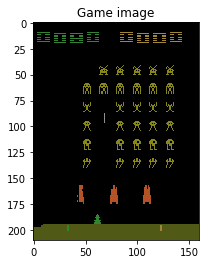

(1, 84, 84, 4)


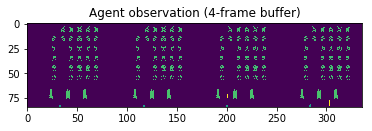

In [58]:
env = CustomGym(game_name="SpaceInvaders-v0", crop=lambda img: img[35:-20, :])

obs_shape = env.observation_shape
n_actions = env.action_size

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())
print("Actions:", env.action_space)

s = env.reset()
accum_reward = 0
for _ in range(100):
    s, reward, _, _ = env.step(random.randint(0,n_actions)-1)
    accum_reward += reward

plt.title('Game image')
plt.imshow(env.env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
print(s.shape)
plt.imshow(s[0].transpose([0,2,1]).reshape([84,-1]))
plt.show()